# Tagup data science challenge

ExampleCo, Inc has a problem: maintenance on their widgets is expensive. They have contracted with Tagup to help them implement predictive maintenance. They want us to provide a model that will allow them to prioritize maintenance for those units most likely to fail, and in particular to gain some warning---even just a few hours!---before a unit does fail.

They collect two kinds of data for each unit. First, they have a remote monitoring system for the motors in each unit, which collects information about the motor (rotation speed, voltage, current) as well as two temperature probes (one on the motor and one at the inlet). Unfortunately, this system is antiquated and prone to communication errors, which manifest as nonsense measurements. Second, they have a rule-based alarming system, which can emit either warnings or errors; the system is known to be noisy, but it's the best they've got. 

They have given us just over 100MB of historical remote monitoring data from twenty of their units that failed in the field. The shortest-lived units failed after a few days; the longest-lived units failed after several years. Typical lifetimes are on the order of a year. This data is available in .csv files under `data/train` in this repository. In addition, they have provided us with operating data from their thirty active units for the past month; this data is available under `data/test` in this repository.

You have two main objectives. First, **tell us as much as you can about the process that generated the data**. Does it show meaningful clustering? Do the observations appear independent? How accurately can we forecast future observations, and how long a window do we need to make an accurate forecast? Feel free to propose multiple models, but be sure to discuss the ways each is useful and the ways each is not useful. Second, **predict which of the thirty active units are most likely to fail**. The data from these units are in `data/test`. Be sure to quantify these predictions, and especially your certainty.

A few notes to help:
1. A good place to start is by addressing the noise due to comm errors. 
2. There is a signal in the data that you can identify and exploit to predict failure.
3. If you can't find the signal in the noise, don't despair! We're much more interested in what you try and how you try it than in how successful you are at helping a fictional company with their fictional problems.
4. Feel free to use any libraries you like, or even other programming languages. Your final results should be presented in this notebook, however.
5. There are no constraints on the models or algorithms you can bring to bear. Some ideas include: unsupervised clustering algorithms such as k-means; hidden Markov models; forecasting models like ARMA; neural networks; survival models built using features extracted from the data; etc.
6. Don't feel compelled to use all the data if you're not sure how. Feel free to focus on data from a single unit if that makes it easier to get started.
7. Be sure to clearly articulate what you did, why you did it, and how the results should be interpreted. In particular you should be aware of the limitations of whatever approach or approaches you take.
8. Don't hesitate to reach out with any questions.

In [71]:
# To help you get started...
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

def load_rms(filename):
    df = pd.read_csv(filename)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

def load_alarms(filename):
    df = pd.read_csv(filename, header=None, names=["timestamp", "message"])
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

rms = load_rms('data/train/unit0000_rms.csv')
alarms = load_alarms('data/train/unit0000_alarms.csv')

display(rms.describe())
display(alarms.describe())

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
count,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04
mean,-8.111152e+46,-4.431337e+60,-1.387827e+56,-6.640742e+69,-1.937422e+48
std,2.456380e+49,1.903274e+63,4.202968e+58,2.011115e+72,5.867349e+50
min,-7.439020e+51,-5.565298e+65,-1.272847e+61,-6.090557e+74,-1.776896e+53
25%,1.017725e+03,2.311319e+02,3.239347e+01,1.179731e+02,6.489677e+01
50%,1.066347e+03,2.667104e+02,3.944687e+01,1.564521e+02,7.799157e+01
75%,1.106721e+03,2.993994e+02,4.607173e+01,1.978223e+02,9.086132e+01
max,7.978110e+44,1.500194e+65,1.555360e+55,3.117856e+55,1.710299e+40


,timestamp,message
count,305,305
unique,305,2
top,2003-12-15 23:29:11.344610850,warning
freq,1,304
first,2003-12-15 19:18:56.526325850,NaN
last,2005-09-10 05:25:11.036412007,NaN


The mean, standard deviation, min and max values tell me that the comm errors are all either very positive or very negative. I am going to remove such data if they are either above 1500 or below -1500. I get these figures by raw eyeballing. 

A raw thresholding is a better idea here instead of using a percentile based cutoff because I don't want to inadvertantly throw away the signal (eg. what if the signal is an unusual bump in say rpm that happened to be higher than 95% of the data but isn't crazy high? In other words, I am looking for suggestive anomalies in the data while throwing away the obviously crazy anomalies.)

                        timestamp  message
282 2005-08-02 16:11:20.797373876  warning
283 2005-08-02 18:48:46.927085733  warning
284 2005-08-08 18:12:41.795821070  warning
285 2005-08-08 21:20:29.395516442  warning


<Figure size 432x288 with 0 Axes>

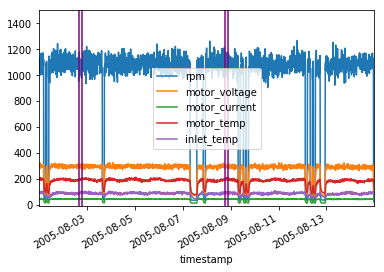

In [73]:
# filter comm errors
def filter_comm_errors(rms):
    columns = ["rpm", "motor_voltage", "motor_current", "motor_temp", "inlet_temp"]
    for col in columns:
        rms = rms[(rms[col] < 1500) & (rms[col] > -1500)]
    return rms

rms = filter_comm_errors(rms)

# pick a specific time interval to analyze
start = pd.to_datetime('8/01/2005')
end = pd.to_datetime('8/15/2005')
rms_chunk = rms.loc[(rms["timestamp"] > start) & (rms["timestamp"] < end)]

# plot the warnings and data together
plt.figure()
ax = rms_chunk.plot(x="timestamp", ylim=(-10, 1500))
warnings = alarms.loc[(alarms["timestamp"] > start) & (alarms["timestamp"] < end)]

for warning in warnings["timestamp"]:
    plt.axvline(x=warning, color = 'purple')
    
print(warnings)

The purple lines are where the warnings are. They seem very noisy. It seems like the warnings go off about a day or two in advance, if ever. On the left side of the graph, two warnings led to only one drop, and while the subsequent two warnings seem to have got two drops, there are a lot of drops for which there were no warnings. A little fiddling with the time frame showed that the warnings get better at pointing out when the downtime occurs but not really at predicting that they are going to happen, so that coupled with the noisiness means that to term them as 'warnings' is misleading.

I was hoping that there would be some hint on what situations cause warnings and what don't, but this initial visualization gives me nothing. I zoomed into the where the warnings were occuring (and where they should have occured but did not) and still did not find a visual pattern. Moving forward, I am going to ignore the warnings altogether.

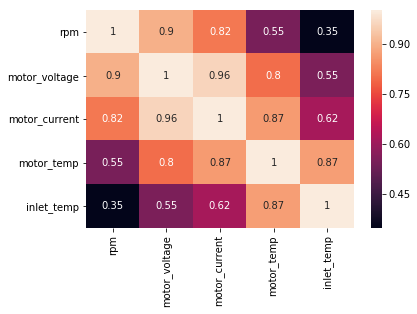

In [74]:
import seaborn as sns
corr = rms.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True)

The observations are not independent. As you would expect, the voltage and current have a high coorelation, and the two temperature readings have a high coorelation. I am surprised that the internal temperature and the rpm are not related highly - you would think that the temperature increases with the kinetic energy.

Next, I want to see if there are some specific datapoints that can somehow signal the downtime. 

I used DBSCAN for this because I don't need to know the number of clusters beforehand - it will just show me all the clusters formed of a certain density. And I can fiddle with its parameters until I can find cluster sizes that show me that they indicate certain behavior. The only downside for DBSCAN in this case is that I need to fiddle with the parameters a bit to get reasonable clusters, but its almost an upside because I can look at all kinds of clusters while doing it and define what a reasonable cluster is. Another downside of DBSCAN is that the parameters that work for this machine might not work for others, but that is not a concern since we are just using it to understand clusters and not predict on a new machine.

While DBSCAN serves us well for this purpose (checking to see if certain datapoints are predictors of downtime), I have made a big assumption in assuming that downtimes can be predicted by individual observations. In using DBSCAN, we lose the time-series information of the data and that is quite a leap to make of time-series data! But while nothing may come of this prediction-wise, this will still be useful in understanding the data better.

Unique labels:  [-1  0  1  2  3  4  5]
Label counts  [  15 1745    8   12  173   34    3]


/Users/bhushansuwal/Desktop/env/tagup/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<Figure size 432x288 with 0 Axes>

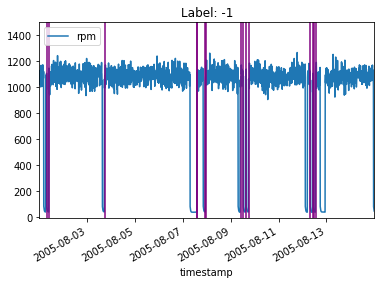

<Figure size 432x288 with 0 Axes>

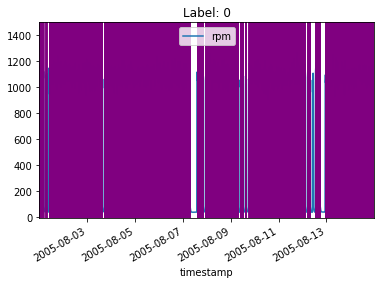

<Figure size 432x288 with 0 Axes>

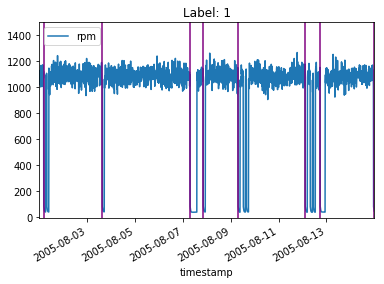

<Figure size 432x288 with 0 Axes>

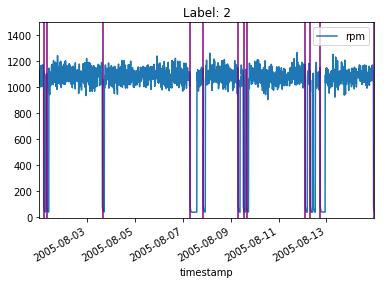

<Figure size 432x288 with 0 Axes>

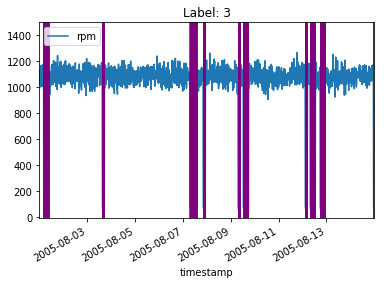

<Figure size 432x288 with 0 Axes>

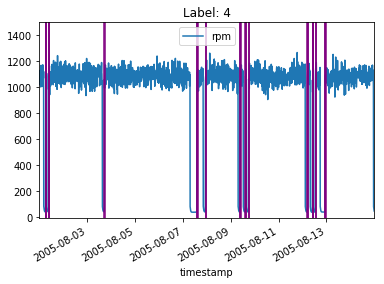

<Figure size 432x288 with 0 Axes>

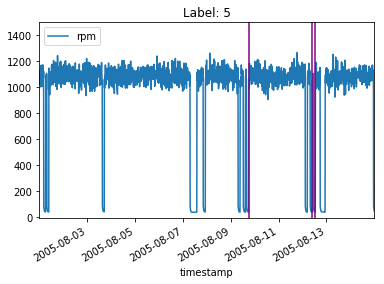

In [75]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import numpy as np

# remove timestamp because DBSCAN() doesn't like that datatype
chunk_wo_timestamp = rms_chunk.loc[:, rms.columns != 'timestamp'].values
# DBSCAN requires scaling of the parameters
chunk_scaled = StandardScaler().fit_transform(chunk_wo_timestamp)

# the eps and min_samples parameters are obtained through trial and error to get two clusters
labels = DBSCAN(eps=0.5, min_samples=3).fit(chunk_scaled).labels_
unique_labels, label_counts = np.unique(labels, return_counts=True)
print("Unique labels: ", unique_labels)
print("Label counts ", label_counts)

# add labels to the dataframe 
rms_chunk['label'] = labels;

def label_clusters(unique_labels, rms_chunk, x_col, y_cols, y_lims):
    # plot the different clusters. 
    for label in unique_labels:
        plt.figure()
        # Plot only the rpm, it is a clear enough visual representative of downtime
        ax = rms_chunk.plot(x=x_col, y=y_cols, ylim=y_lims)
        for index, row in rms_chunk.iterrows():
            if row["label"] == label:
                plt.axvline(x=row[x_col], color = 'purple')
        plt.title("Label: "+ str(label))
        
label_clusters(unique_labels, rms_chunk, "timestamp", ["rpm"], (-10, 1500))

I plotted only the rpm values first since they seem like a very good indicator of downtime. There are some clear clusters formed. 

I am most interested in Clusters 1 and 2, since these are the ones that seem to show when the machine starts failing. Cluster 0 indicates the uptime, Cluster 3 indicates the downtime and Cluster 4 seems to indictate when the machine gets back to life.

I plotted the rest of the data and didn't find anything that I didn't already know.

<Figure size 432x288 with 0 Axes>

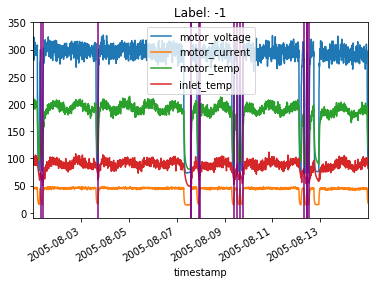

<Figure size 432x288 with 0 Axes>

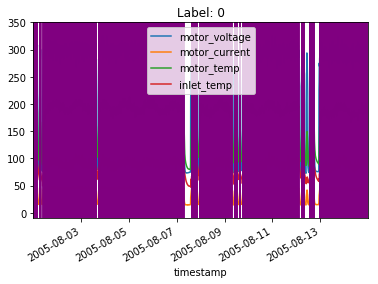

<Figure size 432x288 with 0 Axes>

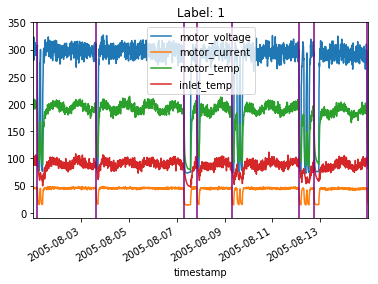

<Figure size 432x288 with 0 Axes>

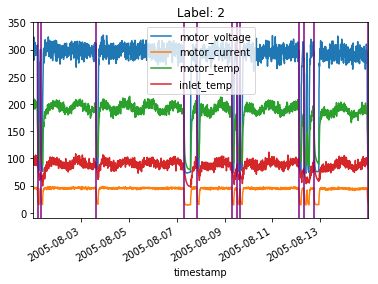

<Figure size 432x288 with 0 Axes>

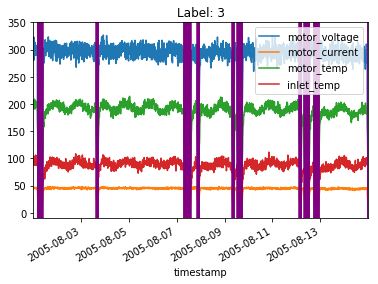

<Figure size 432x288 with 0 Axes>

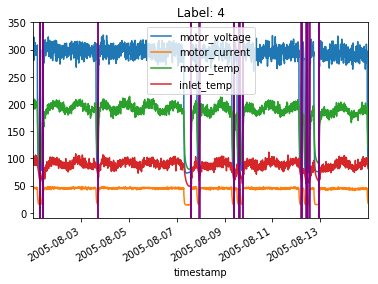

<Figure size 432x288 with 0 Axes>

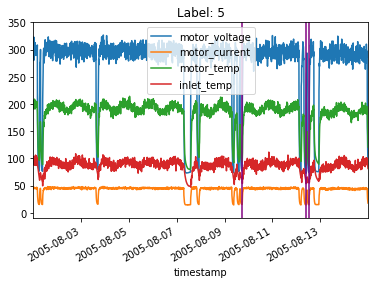

In [76]:
y_cols = ["motor_voltage", "motor_current", "motor_temp", "inlet_temp"]
label_clusters(unique_labels, rms_chunk, "timestamp", y_cols, (-10, 350))

The sequentiality of data does matter then (unsurprising, now that I'm typing this.) But we have atleast eliminated the possibility that some random spikes or fluke data points are causing the downtimes. 

Moving on I am going to analyze Cluster 1, which are the datapoints at the start of machine downtime, to see the characteristics of the start of downtime and see how long it takes for the transition from uptime to downime.

In [77]:
for i in range(len(rms_chunk)):
    if rms_chunk.iloc[i]["label"] == 1:
        # get last 5 observations
        print(rms_chunk[(i-5):i+1])
        print("end of observation")
        print("") 

                          timestamp          rpm  motor_voltage  \
85870 2005-08-01 03:35:22.669090202  1154.359916     298.407017   
85871 2005-08-01 03:45:36.431058063  1005.301749     289.413339   
85872 2005-08-01 03:55:14.482742154  1131.825712     307.523598   
85873 2005-08-01 04:05:37.175599348  1069.473869     298.974397   
85874 2005-08-01 04:16:18.556386206  1121.557898     308.442832   
85875 2005-08-01 04:25:10.250304636    82.831790     165.907330   

       motor_current  motor_temp  inlet_temp  label  
85870      47.070572  201.746377   92.365041      0  
85871      44.035409  204.652316   97.351935      0  
85872      45.563902  195.383175   91.908643      0  
85873      44.685289  198.005902   95.714884      0  
85874      45.892865  189.703446  100.317053      0  
85875      33.058701  182.886693   89.391988      1  
end of observation

                          timestamp          rpm  motor_voltage  \
86223 2005-08-03 14:25:12.770376607  1190.900339     296.740007  

The transition is instantaneous between observations. It's not as if the machine is slowly coming to a halt. This means that the machine might be working perfectly fine but not working 10 minutes later and we would have no warning.

The signal is buried in the last x observations. We can find that number x using an autocorrelation plot.

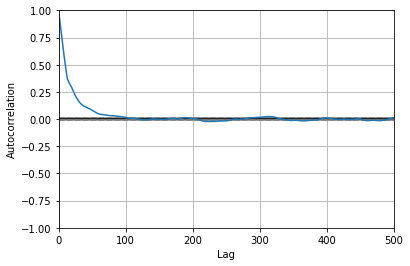

In [78]:
from pandas.plotting import autocorrelation_plot

# There is a positive coorelation between a lag of about 100 previous observations
autocorrelation_plot(rms['rpm'])

plt.xlim([0, 500])
plt.show()

Looks like we need to look at the last ~100 observations. 

Next, I am going to use an LSTM model to predict the machine pattern. I am going to use train from only one of those machines and test it on one of the test machines. LSTMs are a good choice because they deal with long term patterns well. The downside is that even if it works, we will still be no closer to knowing what the signal is. The neural network will know, but we can't interpret its weights. 

In [39]:
import glob

def prepare_dataset(file_pattern, lag):
    x = []
    y = []

    file_paths = glob.glob(file_pattern)
    num_files = 0
    
    for fp in file_paths:
        rms = load_rms(fp)
        
        # remove timestamp
        rms = filter_comm_errors(rms)
        rms = rms.loc[:, rms.columns != 'timestamp']

        # need to scale the parameters for performance
        rms_scaled = pd.DataFrame(StandardScaler().fit_transform(rms), columns=rms.columns)
        
        for i in range(lag, len(rms_scaled)):
            # last lag values for x
            x.append(rms_scaled.iloc[(i-lag):i].values)
            y.append(rms_scaled['rpm'].iloc[i])
            
    return x, y

lag = 100
x_train, y_train = prepare_dataset("./data/train/unit0000_rms.csv", lag)
x_test, y_test = prepare_dataset("./data/test/unit0023_rms.csv", lag)
print("Num training samples ", len(x_train))
print("Num testing samples ", len(x_test))

Num training samples  90185
Num testing samples  1097


Cool, now we have our training and testing dataset. I use the LSTM implementation from https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
to train my data on.

In [40]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

from keras.models import Sequential  
from keras.layers import Dense  
from keras.layers import LSTM  

model = Sequential()
model.add(LSTM(100, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test), verbose=2, shuffle=False)

Train on 90185 samples, validate on 1097 samples
Epoch 1/5
 - 97s - loss: 0.1999 - val_loss: 0.1421
Epoch 2/5
 - 92s - loss: 0.1578 - val_loss: 0.1436
Epoch 3/5
 - 94s - loss: 0.1491 - val_loss: 0.1570
Epoch 4/5
 - 96s - loss: 0.1441 - val_loss: 0.1695
Epoch 5/5
 - 91s - loss: 0.1421 - val_loss: 0.1779


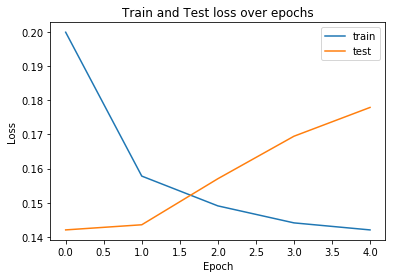

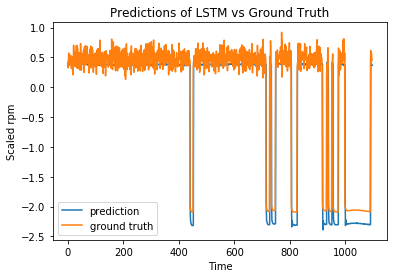

In [80]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Test loss over epochs")
plt.legend()
plt.show()

# predict on only the first 500 
predictions = model.predict(x_test)
plt.figure()
plt.plot(predictions, label='prediction')
plt.plot(y_test, label='ground truth')
plt.xlabel("Time")
plt.ylabel("Scaled rpm")
plt.title("Predictions of LSTM vs Ground Truth")
plt.legend()
plt.show()

I don't know what's up with the test error (at that scale, it doesn't really matter) but the predictions look good enough for us to predict failure. The downside is that we are using right upto our last observation to make this prediction, so we only ~10 mins of downtime warning. Not ideal!

### Predicting machine failure for the test machines
I have a lot to say about the methods I tried to use for this, but I leave that for the end of the document. 

To predict the failure, I needed to have identified the signal, which I did not. I could use an LSTM again if I absolutely had to if my only objective was to predict what machine is going to fail, but I would still have no idea about what the signal is because neural network parameters are hard to interpret.

The method I ended up using here is to completely ignore the rpm, voltage etc data and create a histogram of the lifetimes of the failed machines. I fit a curve over this histogram, and that allows me to make a cumulative distribution curve. For the test machines, the files don't tell me when these machines went into operation. As (an aspiring) data scientist (at Tagup!) I would ask ExampleCo to give me the installation dates of these machines, after which I can give them the probability of failure for each device.

This solution is not ideal because we are treating each machine as a random variable instead of making use of the rich trove of data we have, and we are actually asking for data we do not have and might be impossible to get for all we know. 

/Users/bhushansuwal/Desktop/env/tagup/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


Text(0.5, 1.0, 'Probability of machine failure vs Days of deployment')

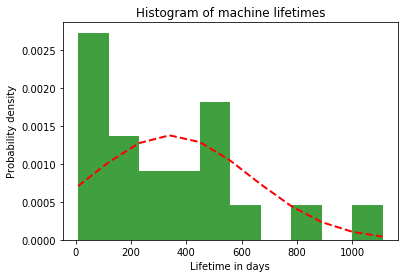

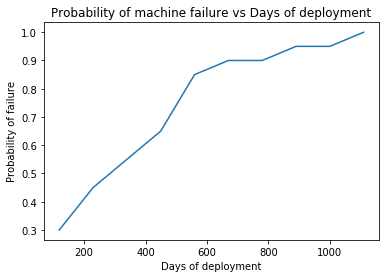

In [81]:
# make a histogram of failure times.
file_paths = glob.glob("./data/train/unit00**_rms.csv")

def find_machine_lifetimes(file_paths):
    lifetimes = []
    for fp in file_paths:
        rms = load_rms(fp)
        lifetime = rms['timestamp'].max() - rms['timestamp'].min()
        lifetimes.append(lifetime.days)
    return lifetimes

lifetimes = find_machine_lifetimes(file_paths)

import matplotlib.mlab as mlab
from scipy.stats import norm
(mu, sigma) = norm.fit(lifetimes)

# the histogram of the data
counts, bins, _ = plt.hist(lifetimes, 10, density=True, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)
plt.title("Histogram of machine lifetimes")
plt.ylabel("Probability density")
plt.xlabel("Lifetime in days")
      
plt.figure()
cdf = np.cumsum(counts)
plt.plot(bin_edges[1:], cdf/cdf[-1])
plt.xlabel("Days of deployment")
plt.ylabel("Probability of failure")
plt.title("Probability of machine failure vs Days of deployment")

"Typical lifetimes are on the order of a year." Corroborated by the best-fit line on that histogram.

## Final Thoughts, Musings, What I would do if I had more time...

#### On Clustering
My original attempt was to cluster the datapoints using spectral clustering. This would have been a good method because the only user input it expects is the sigma, which while difficult to estimate is just a scaling coefficient and a good "guess" can be found through cross-validation. However, I had to abandon this line of thought for the following reasons: 

1. I originally wanted to plot the eigenvalues obtained in the embedding space to see the number of clusters for myself - but apparently sklearn doesn't give you the eigenvalues. What it does is use k-means at the end to cluster the eigenvalues and this comes with the expectance of me knowing what the k is, which I don't like too much but I can make a good guess of k = 3 (for the normal uptime readings, the downtime readings, and the abnormal uptime readings that signal the downtime). If this doesn't give me good clustering, I could cluster with k = 2, which I would expect seperates all uptime readings from the downtime readings. Then I can further cluster on the uptime readings with k = 2 or 3 to see if any clusters signal failure. This in theory should work if there any individual readings do signal failure (I will quickly like to repeat that the k-means is on the eigenvalues of the spectral embedding space where the clusters are nicely seperated, and not on the raw readings.)

2. Turns out sklearn was taking too long to cluster the data. So I went down a rabbithole of trying to implement the clustering myself, but abandoned it because implementing it got tricky. I have however attached my implementation in the email (the file is called graveyard.py, for the file that has my dead ideas) that has my implementation of spectral clustering - but the results didn't quite match the results from the paper I was implementing from https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf so I decided to abandon it altogether.

So I switched to DBSCAN instead.

In hindsight I should not have gone hard on spectral clustering and DBSCAN. My initial motivation for this was to find anomalous datapoints that would signal downtime, but both methods strip away the time dependence features of the data which was not so smart, and was eventually proven to be a wrong decision. 

#### Predictions
I next tried to understand and use ARIMA, but the python package took forever for 100 lag observations, so that was a dead-end. This made me switch to a LSTM, which is a good idea if we want to do predictions because LSTMs do well with long-term patterns. However, this still doesn't get us around the fact that we cannot predict the failure more than ~10 minutes in advance, and we still have no clue about what the actual signal is.  

The prediction problem seems like a textbook survival analysis problem. Here is why I struggled to make a model for our problem. We only have data on machines that failed. We could have used the test dataset machines for observations where the machines have not failed, but we don't know when these machines started operation. If we had some machines that had failed, and some that are running, then the censoring could have allowed us to make a Kaplan-Meier curve. I am unsure how to do it without any censoring data, and I briefly considered picking a random time (like say 200 days) and censor the data myself based on whether the machine had broken down by then or not. But this data tampering felt like a major red flag, and I reminded myself that I didn't know enough about survival analysis to be doing something so wacky. 

If I did get beyond that then I also thought of trying a Cox Hazard model, but it assumes a linear relationship between variables (which might not be true) and that the weights of those variables remain the same during the lifetime of the machine (again, not true since our rpm, voltage etc are always changing.)

#### Ideally, what I would do would be...
to ask Example Co when these test machines were installed and then tell them the probability of failure on any given day using the probability graph above.

#### If I had more time...
I know this is a survival analysis problem. I would learn more about it and solve it. 



#### Thanks! 
Bhushan Suwal
bhushan.suwal@tufts.edu